In [ ]:
!pip uninstall imgaug -y
!pip install imgaug==0.2.5
!pip uninstall matplotlib -y
!pip install matplotlib==3.4.3

In [1]:
!pip install pyvi
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 2.8 MB/s 
     |████████████████████████████████| 965 kB 45.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 45 kB/s 
     |████████████████████████████████| 199 kB 61.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=1973aad35c9300f3f3e1ff5778f05b6edeb34af22514a31065655703e56c4c39
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [32]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

spark = SparkSession.builder.appName("ViHSD_MLLib").config("spark.executor.memory","8g").getOrCreate()

In [45]:
import pandas as pd 
import numpy as np 

DATA = '/content/drive/MyDrive/Colab/BigData/vihsd/train.csv'
DEV_DATA = '/content/drive/MyDrive/Colab/BigData/vihsd/dev.csv'
TEST_DATA = '/content/drive/MyDrive/Colab/BigData/vihsd/test.csv'

pd_train = pd.read_csv(DATA)
pd_dev = pd.read_csv(DEV_DATA)
pd_test = pd.read_csv(TEST_DATA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


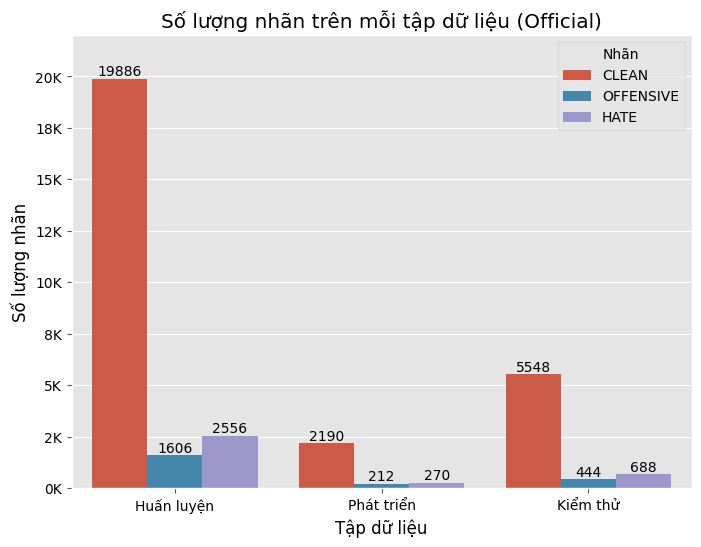

In [51]:
pd_train['set'] = 'Train'
pd_dev['set'] = 'Dev'
pd_test['set'] = 'Test'
df_pd = pd.concat([pd_train, pd_dev, pd_test])
df_pd['counter'] = 1
data = df_pd.groupby(['label_id', 'set']).sum().reset_index().replace({0: 'CLEAN', 1: 'OFFENSIVE', 2: 'HATE'})

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

figure(figsize=(8, 6), dpi=100)
plt.style.use('ggplot')

g = sns.barplot(x = "set", y = "counter", hue='label_id', data = data, order = ["Train", "Dev", "Test"])

g.set_title('Số lượng nhãn trên mỗi tập dữ liệu (Official)', color='black')
g.set_ylabel("Số lượng nhãn", color='black')
g.set_xlabel("Tập dữ liệu", color='black')
h, l = g.get_legend_handles_labels()
label = ['CLEAN', 'OFFENSIVE', 'HATE']
g.legend(h, label, title="Nhãn")
g.set(ylim = (0, 22000))
ylabels = ['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/1000]
g.set_yticklabels(ylabels)
for container in g.containers:
    g.bar_label(container, fontsize=10, color='black')
g.set_xticklabels(['Huấn luyện', 'Phát triển', 'Kiểm thử'])
for tick in g.yaxis.get_major_ticks():
    tick.label1.set_color('black')
for tick in g.xaxis.get_major_ticks():
    tick.label1.set_color('black')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


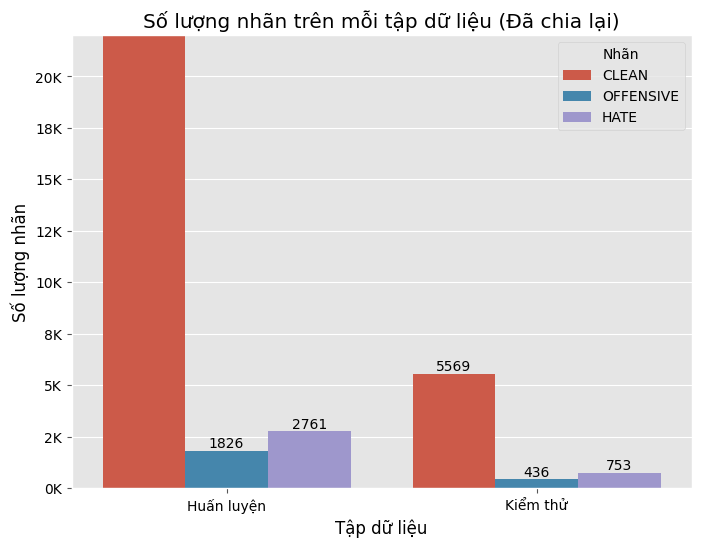

In [42]:
train_pd = train_clean.toPandas()
test_pd = test_clean.toPandas()

train_pd['set'] = 'Train'
test_pd['set'] = 'Test'
df_pd = pd.concat([train_pd, test_pd])
df_pd['counter'] = 1
data = df_pd.groupby(['label_id', 'set']).sum().reset_index().replace({0: 'CLEAN', 1: 'OFFENSIVE', 2: 'HATE'})

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

figure(figsize=(8, 6), dpi=100)
plt.style.use('ggplot')

g = sns.barplot(x = "set", y = "counter", hue='label_id', data = data, order = ["Train", "Test"])

g.set_title('Số lượng nhãn trên mỗi tập dữ liệu (Đã chia lại)', color='black')
g.set_ylabel("Số lượng nhãn", color='black')
g.set_xlabel("Tập dữ liệu", color='black')
h, l = g.get_legend_handles_labels()
label = ['CLEAN', 'OFFENSIVE', 'HATE']
g.legend(h, label, title="Nhãn")
g.set(ylim = (0, 22000))
ylabels = ['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/1000]
g.set_yticklabels(ylabels)
for container in g.containers:
    g.bar_label(container, fontsize=10, color='black')
g.set_xticklabels(['Huấn luyện', 'Kiểm thử'])
for tick in g.yaxis.get_major_ticks():
    tick.label1.set_color('black')
for tick in g.xaxis.get_major_ticks():
    tick.label1.set_color('black')
plt.show()

In [34]:
import pyspark.sql.types as t

schema = t.StructType(
    [t.StructField("free_text", t.StringType(), True),
     t.StructField("label_id", t.IntegerType(), True)]
)

df_train = spark.createDataFrame(pd_train, schema=schema)
df_dev = spark.createDataFrame(pd_dev, schema=schema)
df_test = spark.createDataFrame(pd_test, schema=schema)
df = df_train.union(df_dev).union(df_test)

In [35]:
import re
from pyvi.ViTokenizer import ViTokenizer
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.linalg import Vectors

STOPWORDS = '/content/drive/MyDrive/Colab/BigData/vietnamese-stopwords-dash.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n').strip('\"')
        stopwords.append(dd)
    stopwords = set(stopwords)


def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split()
                if word not in stop_words]
    train_sentences = ' '.join(new_sent)

    return train_sentences


def deEmojify(text):
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'', text)


def preprocess(text, tokenized=True, lowercased=True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    return str(text)


preprocess_udf = f.udf(preprocess, t.StringType())
# array_to_vector = f.udf(lambda a: Vectors.dense(a), VectorUDT())

user_regex = r"(@\w{1,15})"
hashtag_replace_regex = "#(\w{1,})"
url_regex = r"((https?|ftp|file):\/{2,3})+([-\w+&@#/%=~|$?!:,.]*)|(www.)+([-\w+&@#/%=~|$?!:,.]*)"
email_regex = r"[\w.-]+@[\w.-]+\.[a-zA-Z]{1,}"


def pre_process_data(data):
    # Loại bỏ @Mention khỏi comment
    data = (data.withColumn("text_clean", f.regexp_replace(f.col("free_text"), user_regex, ""))
            # Loại bỏ #Hashtag khỏi text
            .withColumn("text_clean", f.regexp_replace(f.col("text_clean"), hashtag_replace_regex, "$1"))
            # Loại bỏ URL khỏi text
            .withColumn("text_clean", f.regexp_replace(f.col("text_clean"), url_regex, ""))
            # Loại bỏ Email khỏi text
            .withColumn("text_clean", f.regexp_replace(f.col("text_clean"), email_regex, ""))
            # Loại bỏ các khoảng trắng thừa trong câu
            .withColumn("text_clean", f.regexp_replace(f.col("text_clean"), " +", " "))
            # Loại vỏ các khoảng trắng đầu và cuối câu
            .withColumn("text_clean", f.trim(f.col("text_clean")))
            # Chuẩn hoá viết thường
            .withColumn("text_clean", f.lower(f.col("text_clean")))
            # Giữ lại các dòng mà đoạn text có nội dung
            .filter(f.col("text_clean") != "")
            # Tiền xử lý dữ liệu
            .withColumn('text_clean', preprocess_udf('text_clean')))

    return data

In [36]:
df_clean = pre_process_data(df)
train_clean, test_clean = df_clean.randomSplit([0.8, 0.2], 0)

# Load model trained

In [20]:
from pyspark.ml import PipelineModel
model_names = ["logistic_regression", "naive_bayes", "decision_tree", "random_rorest"]
trained_model = PipelineModel.load(f"/content/drive/MyDrive/Colab/BigData/ml_model/{model_names[0]}")
trained_model.transform(test_clean).show()

# Logistic Regression

In [8]:
from pyspark.ml.feature import  Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import  IDF
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
count = CountVectorizer(inputCol="words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
lr = LogisticRegression(featuresCol='features', labelCol='label_id')

pipelie = Pipeline(stages=[tokenizer, count, idf, lr])
model = pipelie.fit(train_clean)

In [9]:
model.save('/content/drive/MyDrive/Colab/BigData/ml_model/logistic_regression')

Test set accuracy = 0.8237644273453685
F1 - micro: 0.8237644273453685
F1 - macro: 0.5841856003553061
Accuracy: 0.8237644273453685


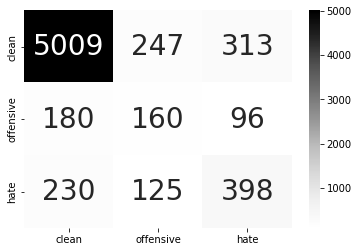

In [10]:
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = model.transform(test_clean)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy", predictionCol='prediction', labelCol='label_id')
print(f"Test set accuracy = {evaluator.evaluate(predictions)}")

pd_prediction = predictions.select('label_id', 'prediction').toPandas()
y_true = pd_prediction['label_id']
y_pred = pd_prediction['prediction']

f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print(f"F1 - micro: {f1_micro}")
print(f"F1 - macro: {f1_macro}")
print(f"Accuracy: {accuracy}")

cf = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf, index = ["clean", "offensive", "hate"], columns = ["clean", "offensive", "hate"])
sns.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 28})

# Naive Bayes

In [11]:
from pyspark.ml.feature import  Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import  IDF
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes

tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
count = CountVectorizer(inputCol="words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", featuresCol='features', labelCol='label_id')

pipeline = Pipeline(stages=[tokenizer, count, idf, nb])
model = pipeline.fit(train_clean)

In [12]:
model.save('/content/drive/MyDrive/Colab/BigData/ml_model/naive_bayes')

Test set accuracy = 0.7767090855282628
F1 - micro: 0.7767090855282627
F1 - macro: 0.5685169505914581
Accuracy: 0.7767090855282628


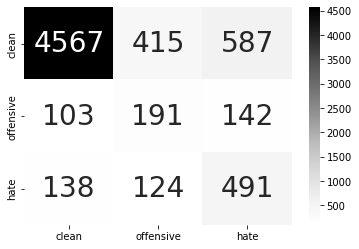

In [13]:
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = model.transform(test_clean)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy", predictionCol='prediction', labelCol='label_id')
print(f"Test set accuracy = {evaluator.evaluate(predictions)}")

pd_prediction = predictions.select('label_id', 'prediction').toPandas()
y_true = pd_prediction['label_id']
y_pred = pd_prediction['prediction']

f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print(f"F1 - micro: {f1_micro}")
print(f"F1 - macro: {f1_macro}")
print(f"Accuracy: {accuracy}")

cf = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf, index = ["clean", "offensive", "hate"], columns = ["clean", "offensive", "hate"])
sns.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 28})

# Decision Tree

In [14]:
from pyspark.ml.feature import  Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import  IDF
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
count = CountVectorizer(inputCol="words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label_id')

pipeline = Pipeline(stages=[tokenizer, count, idf, dt])
model = pipeline.fit(train_clean)

In [15]:
model.save('/content/drive/MyDrive/Colab/BigData/ml_model/decision_tree')

Test set accuracy = 0.8372299496892571
F1 - micro: 0.8372299496892571
F1 - macro: 0.43106659522817464
Accuracy: 0.8372299496892571


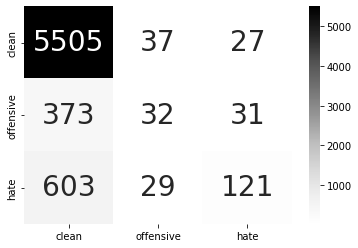

In [16]:
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = model.transform(test_clean)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy", predictionCol='prediction', labelCol='label_id')
print(f"Test set accuracy = {evaluator.evaluate(predictions)}")

pd_prediction = predictions.select('label_id', 'prediction').toPandas()
y_true = pd_prediction['label_id']
y_pred = pd_prediction['prediction']

f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print(f"F1 - micro: {f1_micro}")
print(f"F1 - macro: {f1_macro}")
print(f"Accuracy: {accuracy}")

cf = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf, index = ["clean", "offensive", "hate"], columns = ["clean", "offensive", "hate"])
sns.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 28})

# Random Forest

In [17]:
from pyspark.ml.feature import  Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import  IDF
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier

tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
count = CountVectorizer(inputCol="words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
rf = RandomForestClassifier(featuresCol="features", labelCol="label_id")

pipeline = Pipeline(stages=[tokenizer, count, idf, rf])
model = pipeline.fit(train_clean)

In [18]:
model.save('/content/drive/MyDrive/Colab/BigData/ml_model/random_rorest')

Test set accuracy = 0.824060372891388
F1 - micro: 0.824060372891388
F1 - macro: 0.3011816878937833
Accuracy: 0.824060372891388


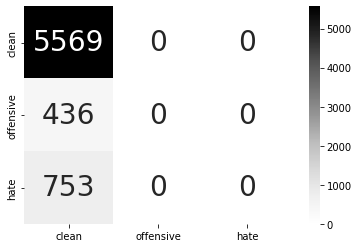

In [19]:
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = model.transform(test_clean)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy", predictionCol='prediction', labelCol='label_id')
print(f"Test set accuracy = {evaluator.evaluate(predictions)}")

pd_prediction = predictions.select('label_id', 'prediction').toPandas()
y_true = pd_prediction['label_id']
y_pred = pd_prediction['prediction']

f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print(f"F1 - micro: {f1_micro}")
print(f"F1 - macro: {f1_macro}")
print(f"Accuracy: {accuracy}")

cf = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf, index = ["clean", "offensive", "hate"], columns = ["clean", "offensive", "hate"])
sns.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 28})